In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from atomsci.ddm.pipeline import diversity_plots as dp
from scipy.spatial.distance import pdist, squareform
import matplotlib.patches as mpatches
import math
import torch
import numpy as np
# import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import shutil
import sys
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/')
sys.path.append('../')
from RF_functions import *
from training_functions import *
from dataset import * 
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
import warnings
warnings.filterwarnings('ignore')
from rdkit import Chem
from rdkit.Chem import AllChem



import sklearn
from sklearn.model_selection import KFold

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

# from scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys


from sklearn.model_selection import GridSearchCV



In [5]:
# method to translate ecfp fingerprints in DF back to bitvectors
from rdkit.DataStructs import ExplicitBitVect
def df_to_bitvect(df):
    bitvects = []
    for _, row in df.iterrows():
        bit_string = ''.join(row.astype(str))
        bitvect = ExplicitBitVect(len(bit_string))
        for i, bit in enumerate(bit_string):
            if bit == '1':
                bitvect.SetBit(i)
        bitvects.append(bitvect)
    return bitvects

In [8]:
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import getpass, os

In [9]:
from atomsci.ddm.pipeline import chem_diversity as cd
from atomsci.ddm.pipeline import dist_metrics
import logging
import matplotlib.pyplot as plt


In [13]:
common_cols = ['base_rdkit_smiles', 'active', 'subset']
datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
for nek in neks: 
    this_nek = f'{nek}'
    print(this_nek)
    mfp_desc = pd.read_csv(f'{datapath}{nek}_MFP_none_scaled.csv') 

    og_test= mfp_desc[mfp_desc['subset']=='test']
    og_train = mfp_desc[mfp_desc['subset']=='train']
    num_train = og_train.shape[0]
    # display(og_train)
    
    # moe_under = pd.read_csv(f'{datapath}NEK{nek}/{short}/NEK{nek}_{bi}_moe_UNDER_df.csv')
    mfp_under = pd.read_csv(f'{datapath}{nek}_MFP_UNDER.csv')
    # under = moe_under.merge(mfp_under, on=['compound_id', 'base_rdkit_smiles', 'subset', 'fold', 'active'])
    under = mfp_under[mfp_under['subset'] == 'train']
    under['subset'] = 'UNDER' 

    
    original_compounds = pd.concat([og_test,og_train, under])
    original_compounds= original_compounds.rename(columns=mfp_dict)
    
    # moe_smote = pd.read_csv(f'{datapath}NEK{nek}/{short}/NEK{nek}_{bi}_moe_SMOTE_df.csv')
    mfp_smote = pd.read_csv(f'{datapath}{nek}_MFP_SMOTE.csv') 
    mfp_smote= mfp_smote.rename(columns=mfp_dict)
    # mfp_smote = mfp_smote.drop(columns=common_cols)
    
    # smote = pd.concat([moe_smote, mfp_smote], axis=1)
    smote_train =mfp_smote[mfp_smote['subset'] == 'train'].copy()
    new_smote=smote_train.iloc[num_train:].copy()
    new_smote['subset'] = 'SMOTE'
    

    df_all = pd.concat([original_compounds, new_smote])
    print(df_all['subset'].value_counts())
    

    dists,fig,ax=plot_tani_dist_distr(df_all, 'base_rdkit_smiles', this_nek, ref_subset='test',radius=2, subsets=True, featurized=True)
    fig.savefig(f'kde_train_dists/{nek}_tanimoto_dists_from_TEST.png', bbox_inches='tight',dpi=300)



NEK2_binding


NameError: name 'mfp_dict' is not defined

[ 89250 773956 654571 438878 433015 858597  85945 697368 201469  94177]


KeyboardInterrupt: 

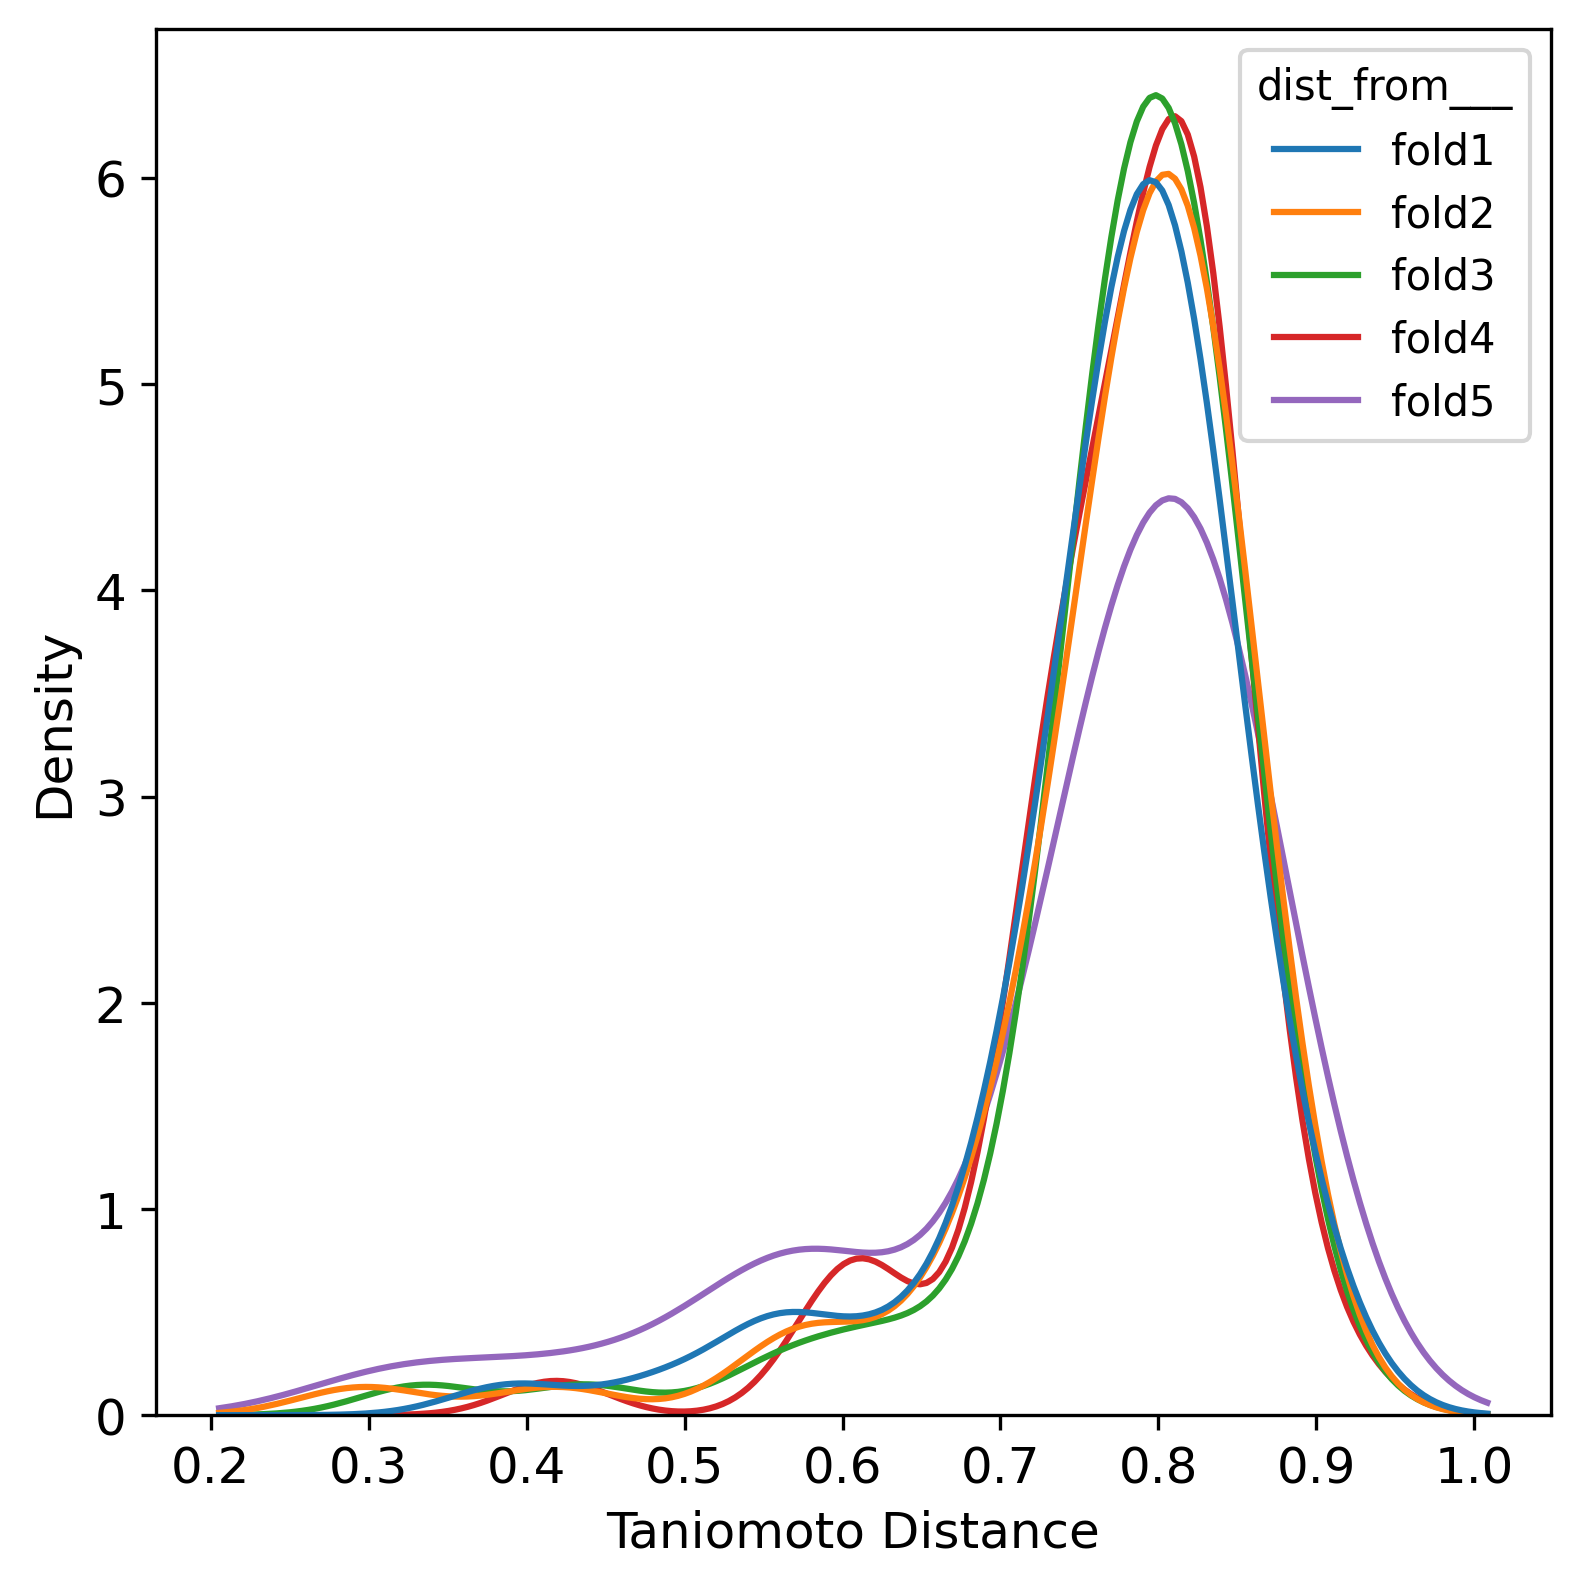

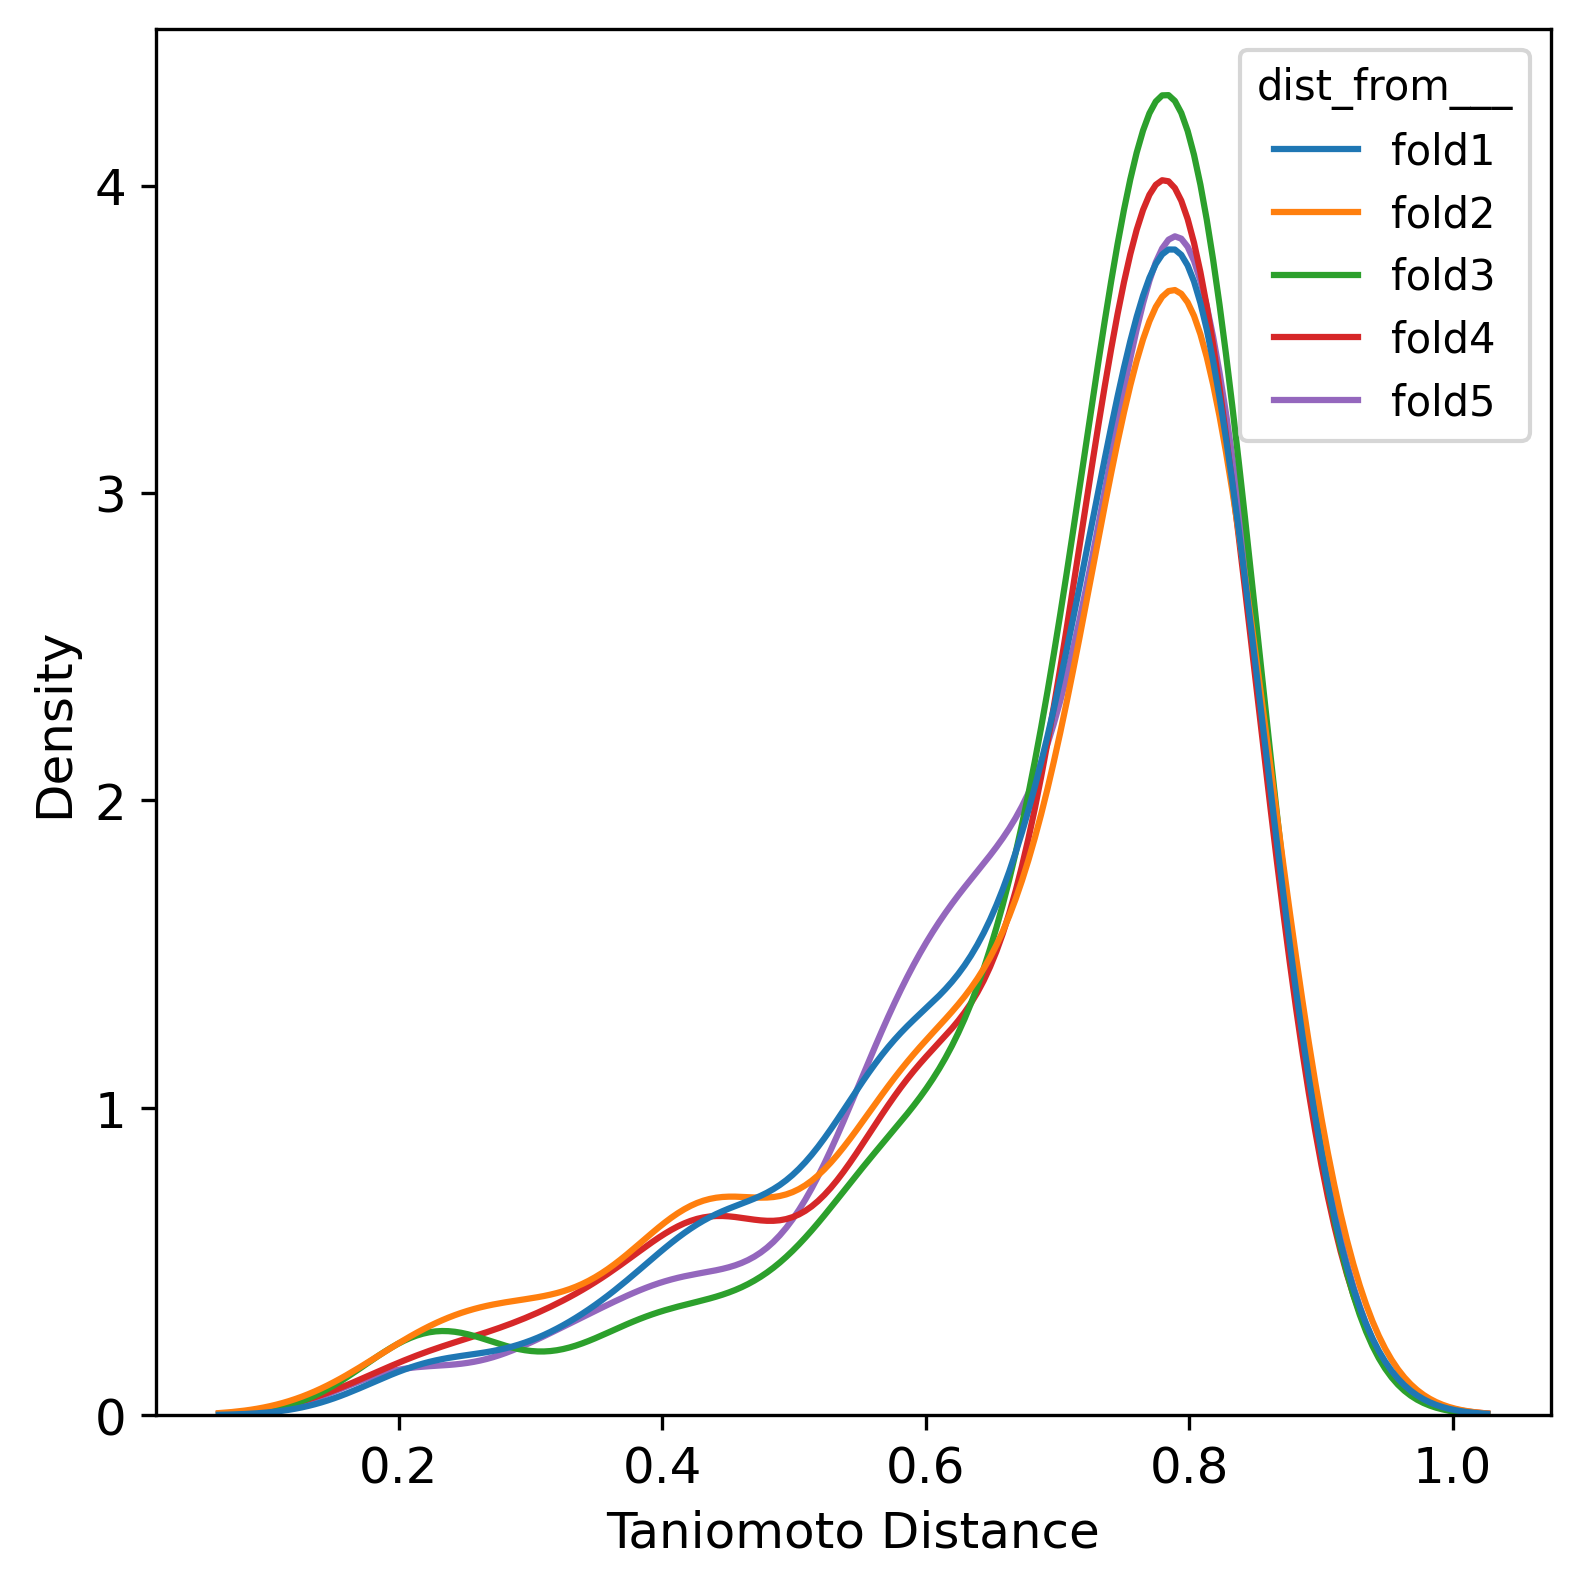

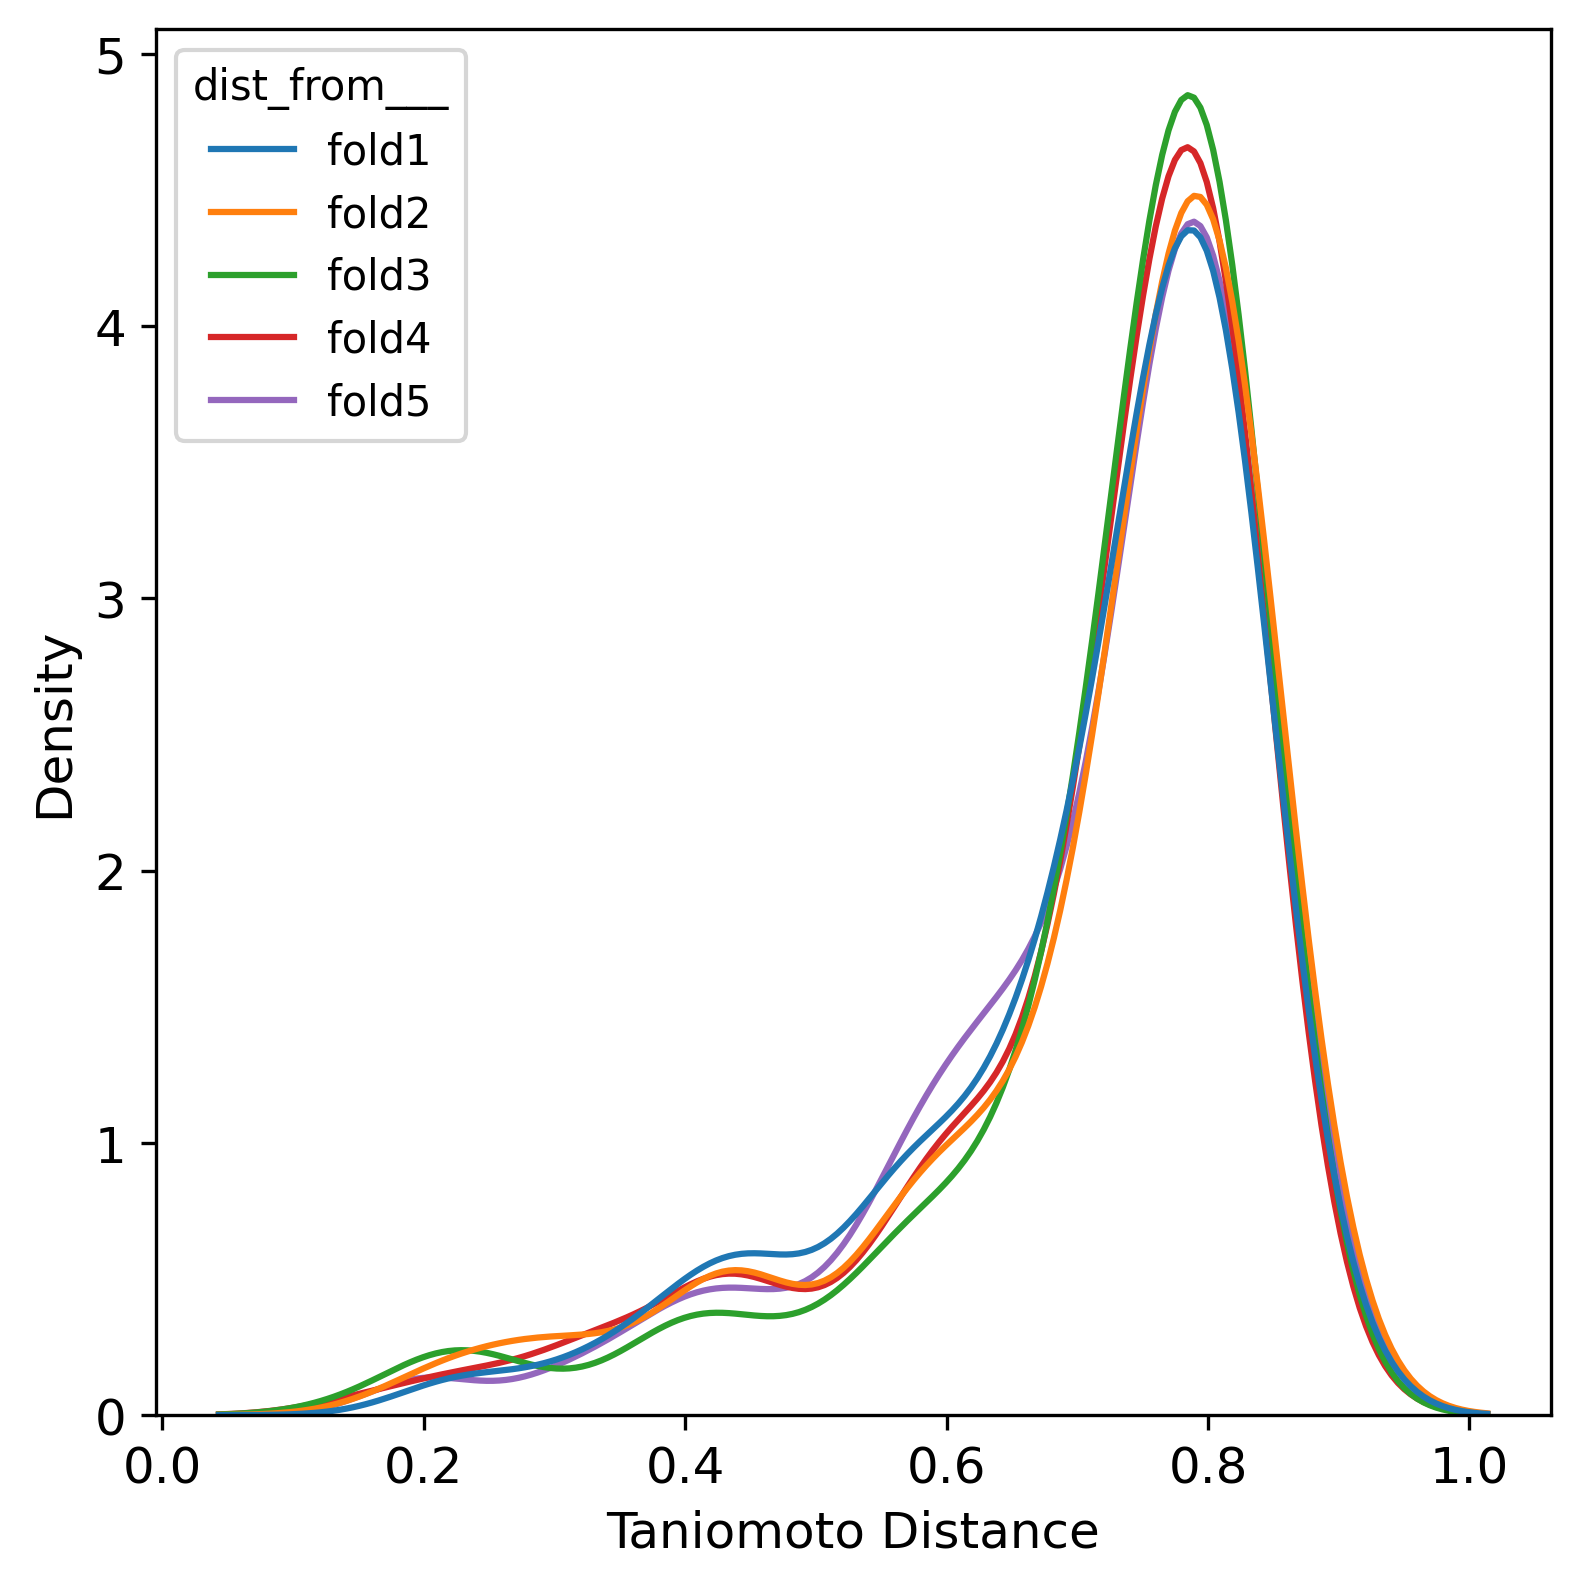

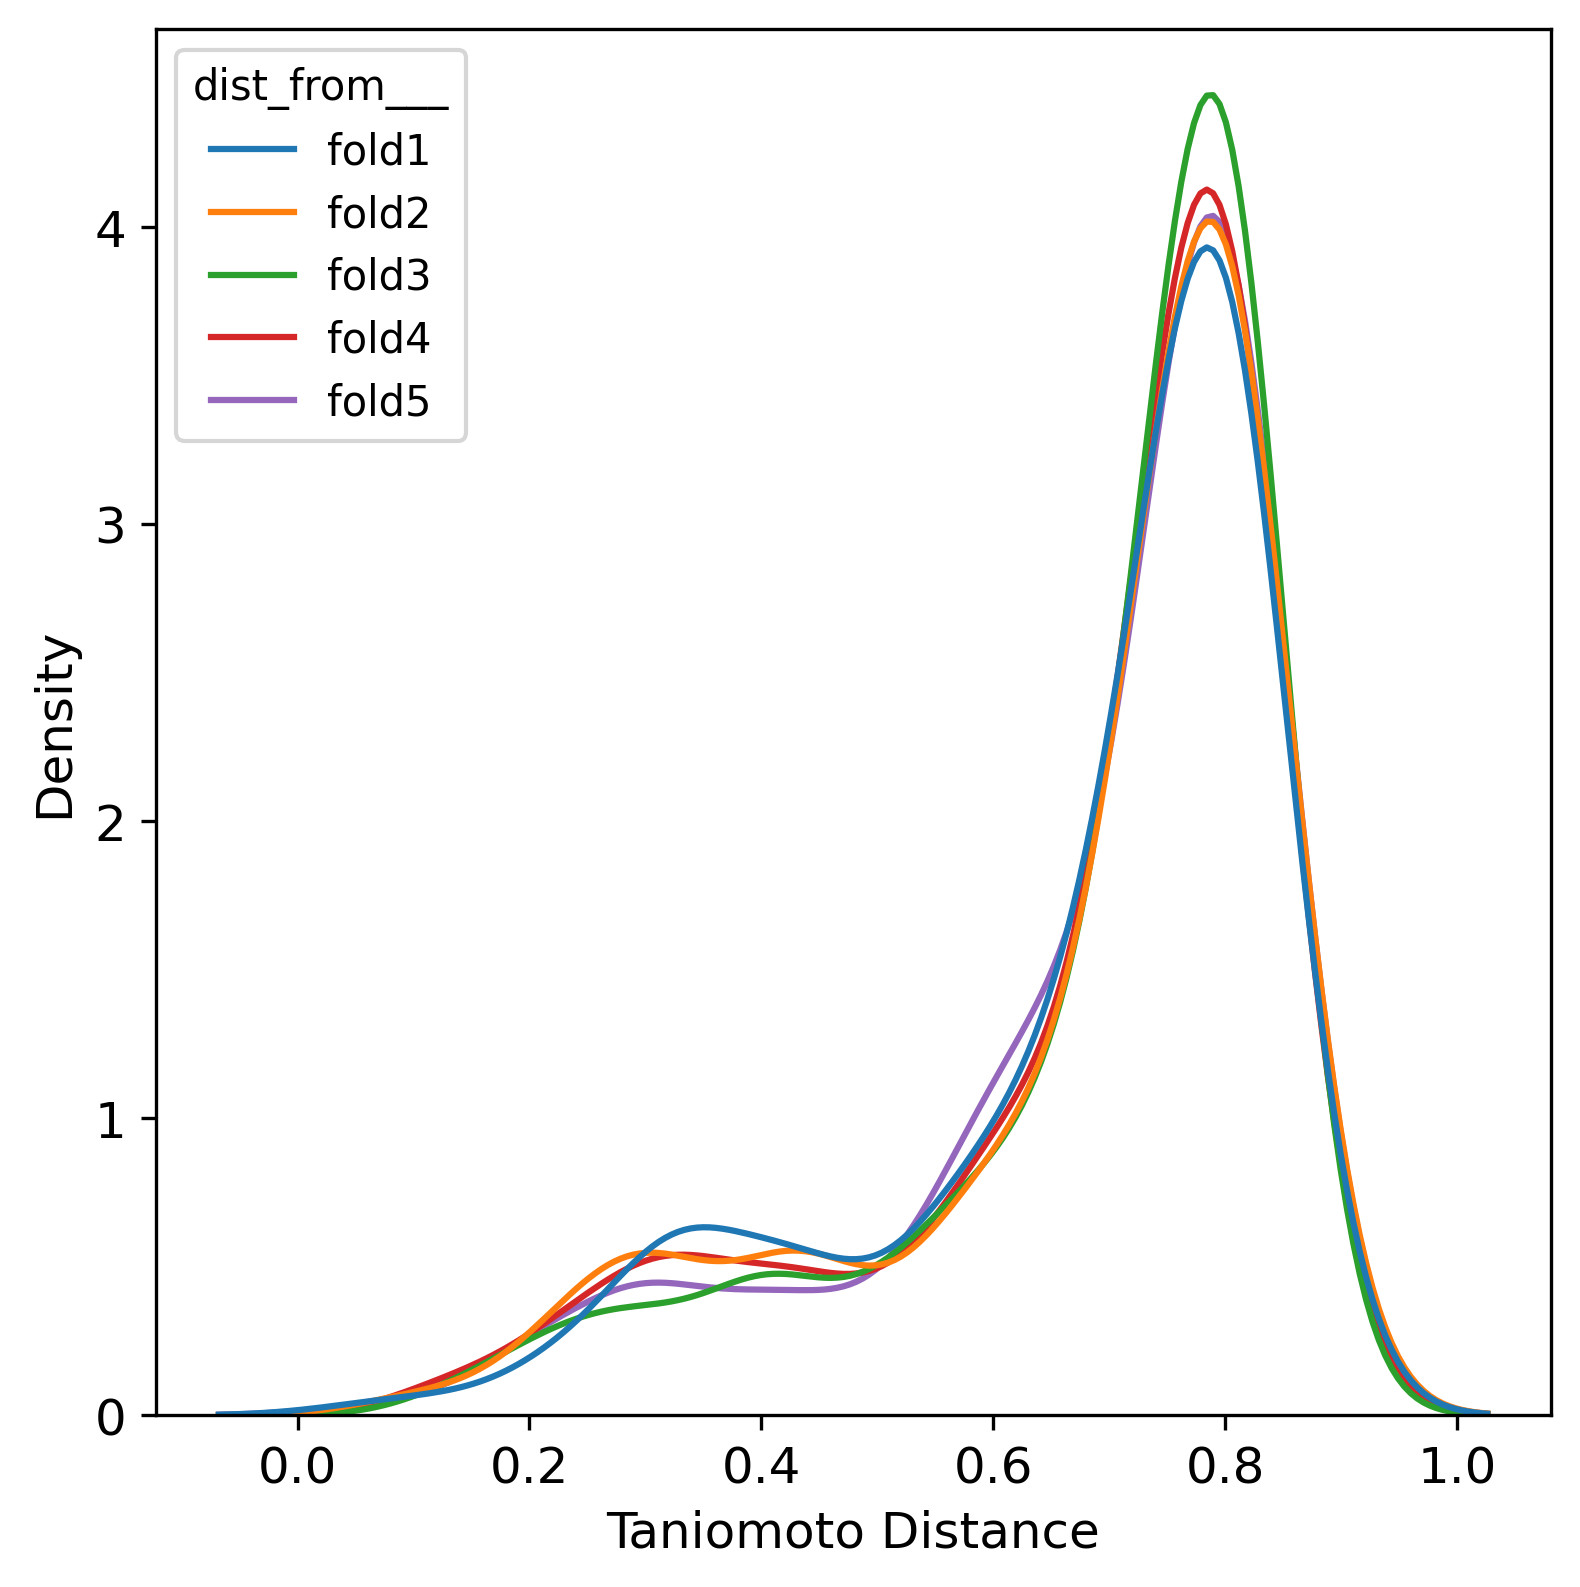

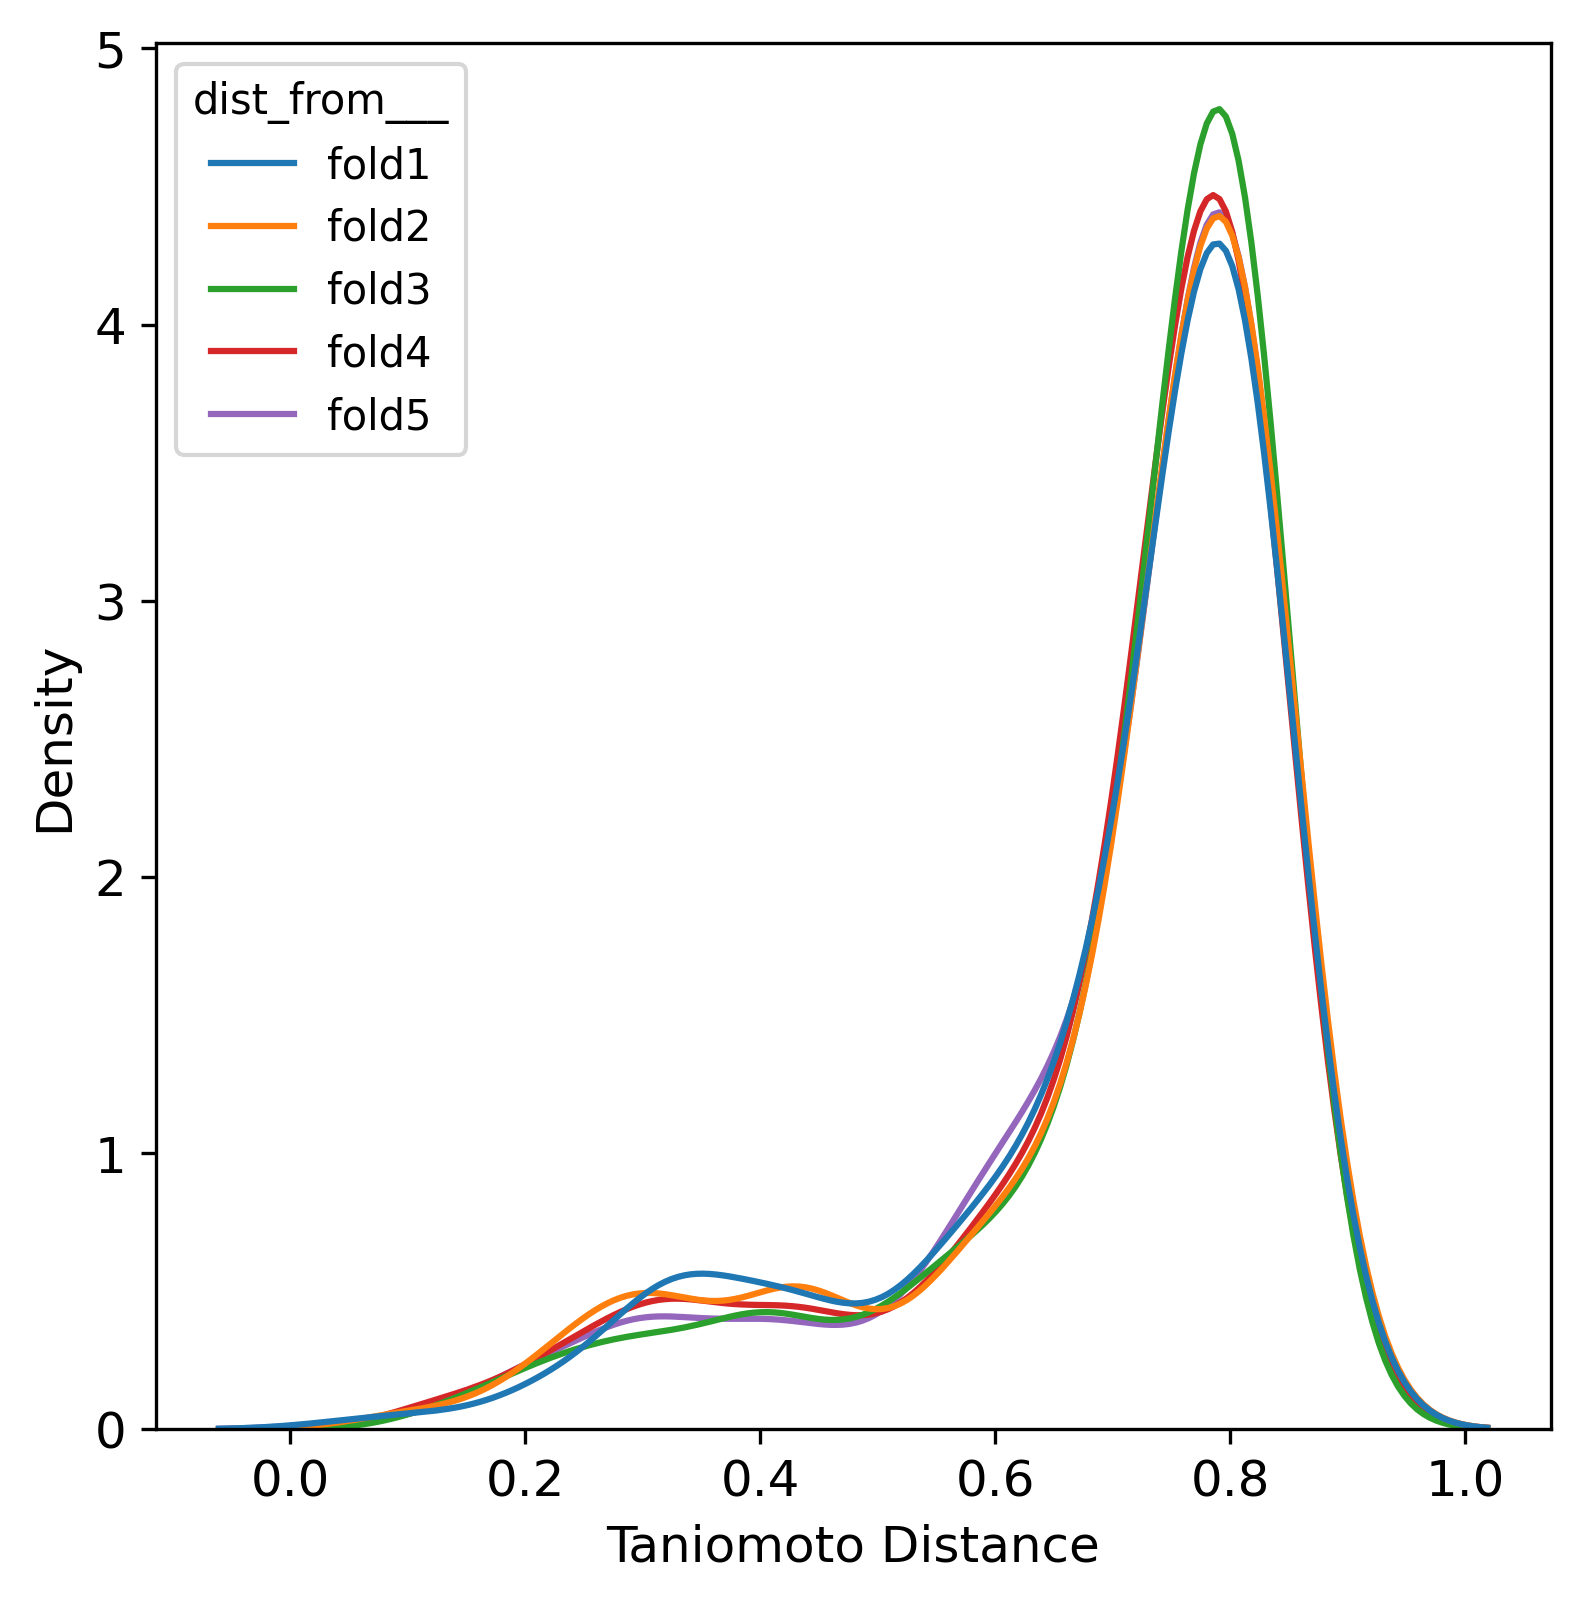

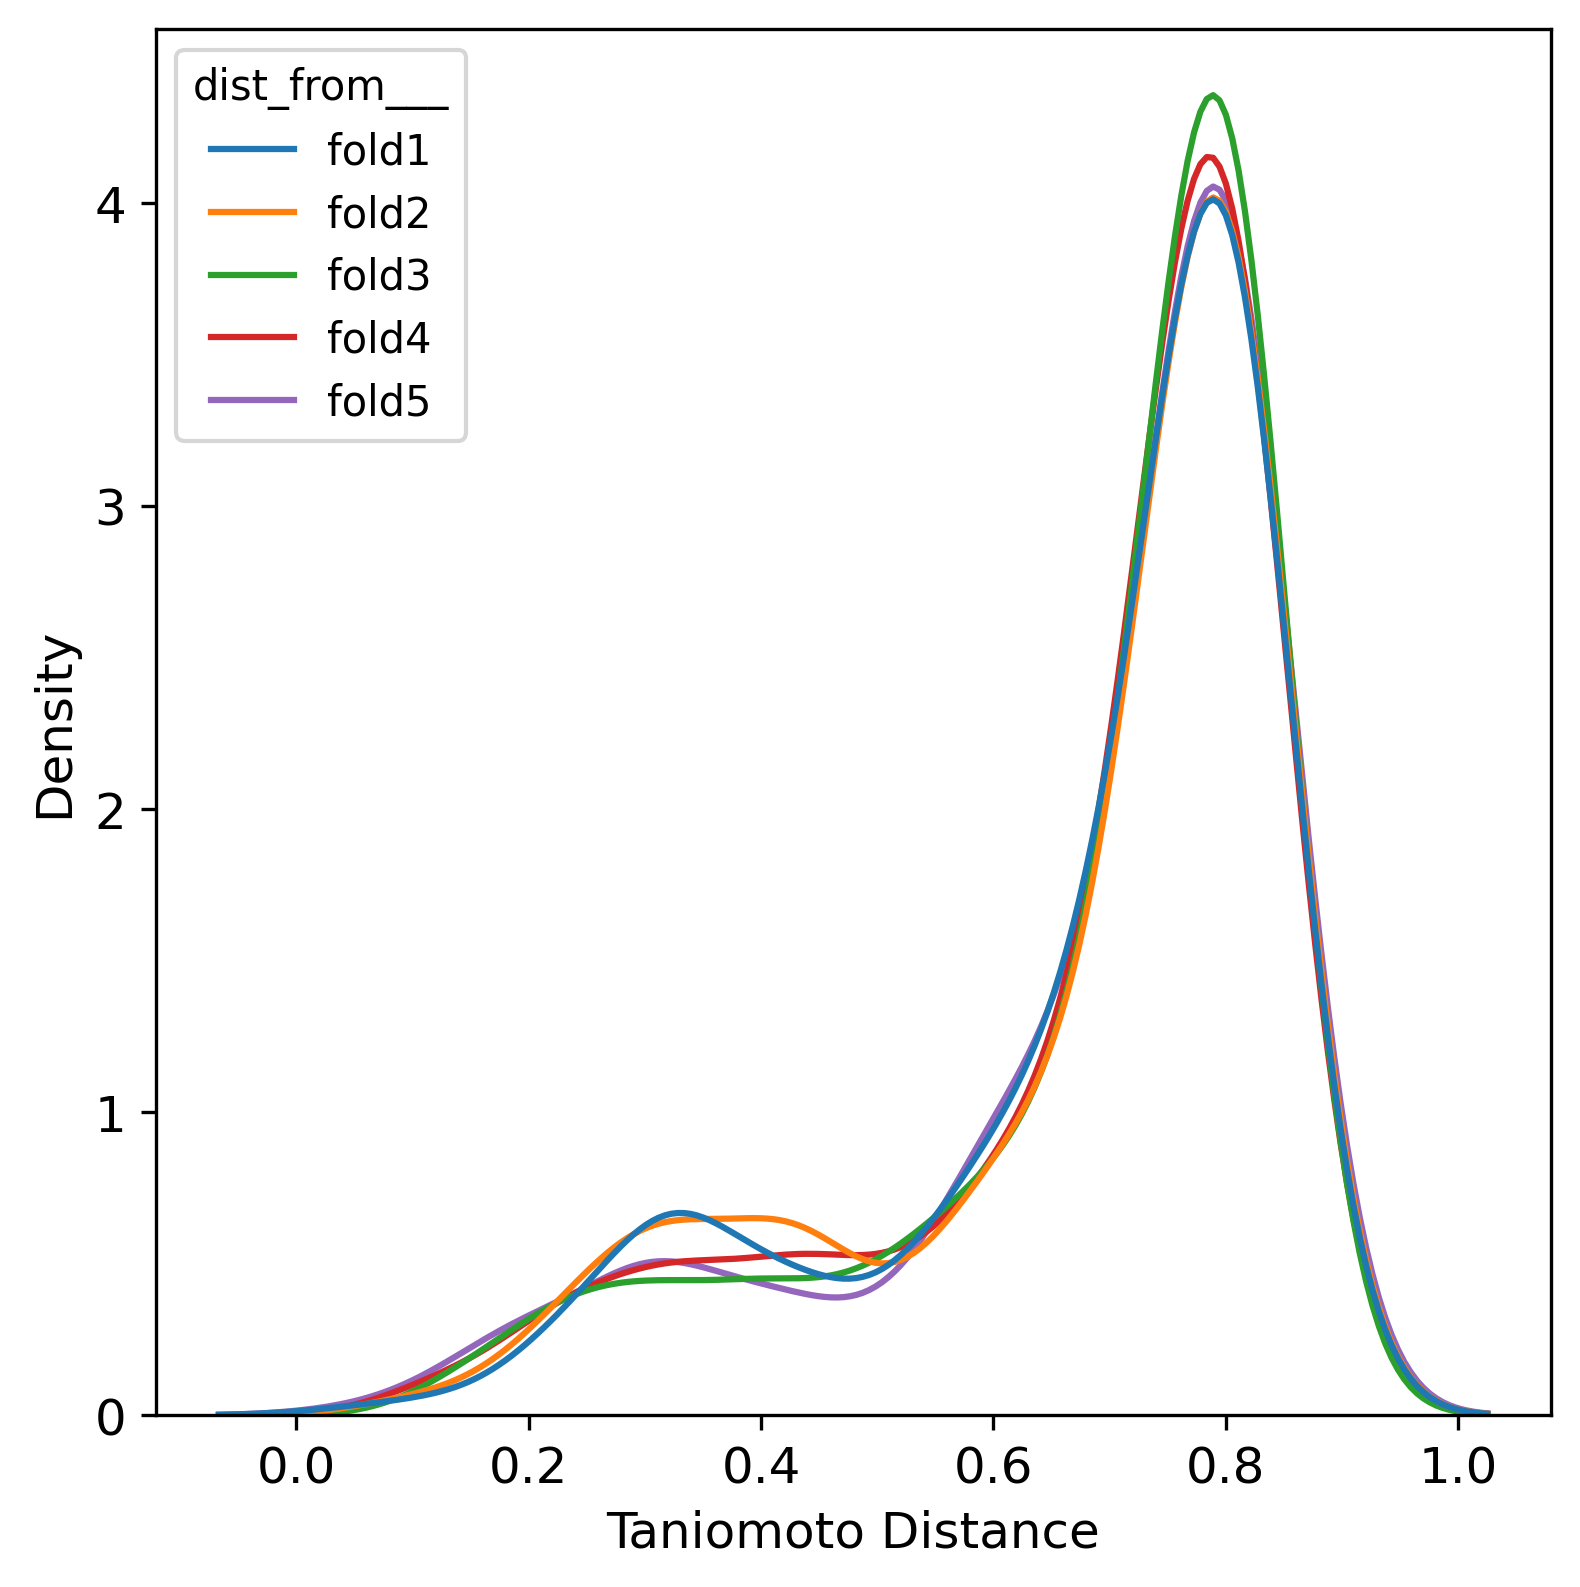

In [ ]:

neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
feats=['MFP'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']
train_results = []
test_results=[]
final_cols=['model','NEK','strategy','feat_type','RF_type', 'cm','recall', 'specificity', 'accuracy', 'precision', 
            'f1', 'ROC_AUC', 'MCC', 'balanced_accuracy', 'fold', 'iteration']
folds=['fold1','fold2','fold3','fold4','fold5']
rng = np.random.default_rng(seed=42) # Create a Generator object with a seed 
numbers = rng.integers(low=0, high=1e6, size=10)  # Generate random numbers
print(numbers)
count=0
fold_labels = [] #the list ofwhich fold is the validation fold 
kfold_dists = []
for i, num in enumerate(list(numbers[0:2])): 
    for nek in neks[0:]:   
        split_df = pd.read_csv(f'{data_path}{nek}_MFP_UNDER.csv')
        train=split_df[split_df['subset']=='train'] 
        folded_train_df = create_folds(train,num) # 5 fold split (validation models) in this iteration 
        for fold in folds: # then use these 5 folds for train/validation 
            kfold_df=label_subsets(folded_train_df, fold, 'test') 

            featurized_df = featurize(feat_type='MFP', df=kfold_df,mfp_radius=2, nBits=2048)
            sampled_df = under_sampling(data_path=None,filename=None,df=featurized_df)  
            id_cols = ['NEK', 'compound_id','base_rdkit_smiles','subset', 'active'] 
            
            fold_labels.append(fold) 

            
            dists = get_tani_dist_distr(sampled_df,'base_rdkit_smiles', radius=2, subset_col='subset', subsets=True, ref_subset='test')
            dists['dist_from___'] = fold

            kfold_dists.append(dists)
        all_kfold_dists = pd.concat(kfold_dists)
        fig, ax = plt.subplots(1, figsize=(6,6), dpi=300)
        sns.kdeplot(data=all_kfold_dists, x='dist', hue='dist_from___', legend=True, common_norm=False, common_grid=True, fill=False, ax=ax)
        ax.set_xlabel('Taniomoto Distance')
        ax.set_ylabel('Density')
                
            # trainX, train_y, testX, test_y=get_arrays(file_path=None, root_name=None, df=sampled_df,nonfeat_cols=id_cols)
                
            

In [23]:
def get_tani_dist_distr(df, smiles_col, radius=2, subset_col='subset', subsets=True, 
                         ref_subset='test'):
    num_cmpds = len(df)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    dists=pd.DataFrame([], columns=['dist','subset'])
    for subs in df[subset_col].unique():
        if subs==ref_subset:
            continue
        smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values 
        smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
        
        diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type='nearest', num_nearest=1)

        diststmp = diststmp.flatten()
        substmp=[subs]*len(diststmp)
        diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist','subset'])
        dists=pd.concat([dists,diststmp])
    dists=dists.reset_index(drop=True)
    return dists